<a href="https://colab.research.google.com/github/CharlesArnal/Deep_Atlas/blob/main/PCAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Headers

In [ ]:
#%load_ext tensorboard
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import plot_model
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import datetime
from copy import deepcopy
import math
import pickle
import scipy.io as sio
import sklearn.datasets
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.svm import LinearSVC

from scipy.stats import iqr

tfk = tf.keras
tfkl = tf.keras.layers
tfpl = tfp.layers
tfd = tfp.distributions

# PCAE

In [ ]:
# Used for the encoders and the decoders
# dim_layers is a list of integers describing the dimension of each layer (the output layer being last)
# activation_functions is a list of Tensorflow activation functions describing the activation function to be used for each layer
# Example: test_model = create_FFNN([4,5],[tf.nn.tanh,tf.exp])
def create_FFNN(dim_layers, activation_functions):
  model = tf.keras.Sequential()
  for layer_index,layer_dim in enumerate(dim_layers):
    model.add(tf.keras.layers.Dense(layer_dim, activation=activation_functions[layer_index]))
  return model

# Combination of an encoder and a decoder (both are FFNNs)
# Specify the dimension of the layers of the encoder, their activation functions, the dimensions of the layers of the decoder, and their activation functions
# (nonsensical) example: test_chart = Chart([4,5],[tf.nn.tanh,tf.tanh],[3,9,6],[tf.nn.tanh,tf.tanh,tf.exp])
class Chart(tf.keras.Model):
    def __init__(self, dim_layers_encoder, activation_functions_encoder,dim_layers_decoder, activation_functions_decoder, **kwargs):
        super(Chart, self).__init__(**kwargs)
        self.encoder = create_FFNN(dim_layers_encoder, activation_functions_encoder)
        self.decoder = create_FFNN(dim_layers_decoder, activation_functions_decoder)
        # We have to save those informations to easily make copies of the charts in the PCAE model
        self.dim_layers_encoder = dim_layers_encoder
        self.activation_functions_encoder = activation_functions_encoder
        self.dim_layers_decoder = dim_layers_decoder
        self.activation_functions_decoder = activation_functions_decoder

    def call(self, x):
      z = self.encode(x)
      x_reconstructed = self.decode(z)
      return [z,x_reconstructed]

    def encode(self,x):
      return self.encoder(x)

    def decode(self,z):
      return self.decoder(z)

    # Returns a new Chart that has the same weights (though they are not shared),
    # plus some small random noise
    # The Chart must have been built/used on some data before
    def create_copy_with_noise(self,noise_std = 0.025):
      copied_chart = Chart(self.dim_layers_encoder, self.activation_functions_encoder,self.dim_layers_decoder, self.activation_functions_decoder)
      input_dim = len(self.encoder.layers[0].get_weights()[0])
      copied_chart.build(input_shape = (None, input_dim))
      copied_chart.set_weights(self.get_weights())
      # copied_chart = deepcopy(self) DEEPCOPY DOES NOT WORK
      for weight in copied_chart.trainable_weights:
        weight.assign_add(tf.random.normal(weight.get_shape(),mean=0.0,stddev=noise_std))
      return copied_chart
    

"""
test_chart = Chart([4,5],[tf.nn.tanh,tf.tanh],[3,9,6],[tf.nn.tanh,tf.tanh,tf.exp])
test_chart.build([None,3])
test_chart.summary()
tf.print(test_chart.encoder.output_shape[-1])
"""

# The output layer should be a Dense layer with activation function None
# The rest_of_the_network can be anything (including None)
class Gating_network(tf.keras.Model):
    def __init__(self, output_layer, rest_of_the_network = None, **kwargs):
        super(Gating_network, self).__init__(**kwargs)
        self.output_layer = output_layer
        self.rest_of_the_network = rest_of_the_network

    def call(self, x):
      if self.rest_of_the_network is not None:
        y1 = self.rest_of_the_network(x)
        y = self.output_layer(y1)
      else:
        y = self.output_layer(x)
      return y

    # Splits an output unit into two copies of itself such that each 
    # gets part of the points currently assigned to that unit
    # The Gating_network should have been built before calling split_output_unit
    # TODO: make code slightly less ad-hoc?
    def split_output_unit(self, points_currently_assigned, unit_index, clustering_space = "encoding_space", clustering_alg = "k_means", encoding_points_currently_assigned = None, perturbation_scale = 0.03):
      [saved_mult_weights,saved_biases] = self.output_layer.get_weights()[-2:]
      previous_number_of_output_units = len(saved_biases)
      output_dim_rest_of_the_network = len(saved_mult_weights)
      
      # add a new output unit (copy of the unit of index unit_index)
      new_biases = np.append(saved_biases,saved_biases[unit_index])
      new_mult_weights = np.append(saved_mult_weights,np.array([saved_mult_weights[:,unit_index]]).transpose(), axis = 1)
      
      # Use a clustering algorithm either in the input space, in the encoding space, or in the codomain of self.rest_of_the_network
      if clustering_alg == "k_means":
        clusterer = KMeans(n_clusters=2, random_state=0)
      elif clustering_alg == "agglom_clustering":
        clusterer = AgglomerativeClustering(n_clusters=2,linkage="single")
      else:
        tf.print("Invalid clustering algorithm")
        return -1

      if self.rest_of_the_network is not None:
        nonlinear_mapping_of_the_points = self.rest_of_the_network(tf.convert_to_tensor(points_currently_assigned)).numpy()
      else:
        nonlinear_mapping_of_the_points = points_currently_assigned
        
      if clustering_space == "input_space":
        clusterer.fit(points_currently_assigned)
      elif clustering_space == "gating_network_encoding_space":
        clusterer.fit(nonlinear_mapping_of_the_points)
      elif clustering_space == "encoding_space":
        clusterer.fit(encoding_points_currently_assigned)
      # Separate using Linear SVM
      svc = LinearSVC()
      svc.fit(nonlinear_mapping_of_the_points,clusterer.labels_)
      # The separating hyperplane is of the shape hyperplane_vector *x + intercept = 0
      hyperplane_vector, intercept = svc.coef_[0], svc.intercept_
      # Renormalize
      magnitude_correction = perturbation_scale*tf.reduce_mean(tf.math.reduce_euclidean_norm(saved_mult_weights, axis = 0))/(np.linalg.norm(hyperplane_vector)+10**(-8))
      hyperplane_vector, intercept = hyperplane_vector * magnitude_correction, intercept*magnitude_correction
      # Add to the new unit the classification function from the SVM
      new_biases[-1] += intercept
      for i in range(output_dim_rest_of_the_network):
        new_mult_weights[i][-1] += hyperplane_vector[i]
      """ # legacy
      # add small noise to both copies
      new_biases[unit_index] += np.random.normal(loc=0.0,scale=noise_std)
      new_biases[-1] +=np.random.normal(loc=0.0,scale=noise_std)
      for i in range(output_dim_rest_of_the_network):
        new_mult_weights[i][unit_index] += np.random.normal(loc=0.0,scale=noise_std)
        new_mult_weights[i][-1] += np.random.normal(loc=0.0,scale=noise_std)
      if self.rest_of_the_network is not None:
        for weight in self.rest_of_the_network.trainable_weights:
          weight.assign_add(tf.random.normal(weight.get_shape(),mean=0.0,stddev=noise_std))
      """
      # create and save the new output_layer
      self.output_layer = tf.keras.layers.Dense(previous_number_of_output_units+1, activation = None )
      self.output_layer.build(input_shape = (None,output_dim_rest_of_the_network) )
      self.output_layer.set_weights([new_mult_weights,new_biases])
      return {"class0": [x for index, x in enumerate(points_currently_assigned) if clusterer.labels_[index] ==0 ],\
        "class1": [x  for index, x in enumerate(points_currently_assigned) if clusterer.labels_[index] == 1] }

"""
v = tf.constant([[0,2],[3,4],[-1,7]])
test1 = Gating_network(tf.keras.layers.Dense(2, activation=None),tf.keras.layers.Dense(3, activation=None))
#test1 = Gating_network(tf.keras.layers.Dense(2, activation=None),None)
test1(v)
tf.print(test1.output_layer.get_weights())
test1.split_output_unit(1,100)
tf.print(test1.output_layer.get_weights())
"""

class PCAE(tf.keras.Model):
  def __init__(self, list_of_charts=[],gating_network=None, charts_weights_inside_norm = False, load_softmax_like = False,load_softmax_exponent =5, softmax_exponent = 1.0, alpha_load=0.1, alpha_importance= 0.1, alpha_classification = 0, alpha_inverse_reconstruction = 0, **kwargs):
    super(PCAE, self).__init__(**kwargs)

    # Basic elements:
    #-----------
    # Must be a list of Charts objects
    self.list_of_charts = list_of_charts
    # Must be a Gating_network object
    self.gating_network = gating_network

    # Variations:
    #-----------
    # Allows for a more extreme softmax (the larger it is, the more weight the largest values have)
    self.softmax_exponent = softmax_exponent
    # Small variation during training:
    # if False, the loss is \sum_i \alpha_i ||\psi_i(\phi_i(X))-X||^2
    # if True, the loss is ||\sum_i \alpha_i \psi_i(\phi_i(X))-X||^2
    # (where alpha_i are the weights of the charts)
    self.charts_weights_inside_norm = charts_weights_inside_norm
    # Different way to compute the load loss
    # Rmk: load_softmax_exponent needs to be large (at least 3 or 4), as it is used
    # on softmax_weights (that are between 0 and 1)
    self.load_softmax_like = load_softmax_like
    self.load_softmax_exponent = load_softmax_exponent
    # Weights for different losses
    # alpha_inverse_reconstruction and alpha_classification can only be non 0 if
    # training is run in eager mode
    self.alpha_load = alpha_load
    self.alpha_importance = alpha_importance
    self.alpha_inverse_reconstruction = alpha_inverse_reconstruction
    self.alpha_classification = alpha_classification




  def call(self, x, training=False):
    # x of shape [batch_size, dim_input]
    # The gating network outputs a tensor of shape [batch_size,num_charts]
    # which gives a weight to each chart (for a given point)
    weights_charts = self.gating_network(x)
    if training:
      # Modified softmax; softmax_weights of shape [batch_size, num_charts]
       # TODO : check if ok
      renormalized_weights_charts = weights_charts - tf.stop_gradient(tf.reduce_max(weights_charts, axis =-1, keepdims = True))
      softmax_weights = tf.math.divide(tf.exp(renormalized_weights_charts*self.softmax_exponent) , tf.expand_dims(tf.reduce_sum(tf.exp(renormalized_weights_charts*self.softmax_exponent), axis = -1), -1) )
      # batch_size = x.get_shape().as_list()
      # z is only used for the inverse reconstruction loss in training mode
      z_output = []
      x_reconstructed_output = []
      for chart_index, chart in enumerate(self.list_of_charts):
        # z and x_reconstructed of shape [batch_size, dim_x/z]
        [z,x_reconstructed] = chart(x)
        x_reconstructed_output.append(x_reconstructed)
        z_output.append(z)
        # x_reconstructed_output and z_output are lists (of size num_charts) of tensors of shape [batch_size, dim_x/z]
      return [z_output, softmax_weights, x_reconstructed_output]
    else:
      # For each point of the batch, we find the index of the chart with the largest weight
      # index_chart is of shape [batch_size]
      indices_chart = tf.math.argmax(weights_charts,1)
      z_output = []
      x_reconstructed_output = []
      # The loop goes over each point of the batch
      # TODO check how that impacts performance; it should be possible to parallelize this,
      # or at least do it in a more elegant way
      for point_in_batch,index_chart in enumerate(indices_chart):
        # Encode each point of the batch using the encoder of the selected chart,
        # then decode it using its decoder
        # tf.expand_dims(x[point_in_batch,:], axis=0) is of shape [1,dim_x]
        [z,x_reconstructed] = self.list_of_charts[index_chart](tf.expand_dims(x[point_in_batch,:], axis=0))
        # z and x_reconstructed are of shape [1,dim_x/z] - we squeeze them to get tensors of thape [dim_x/z]
        z_output.append(tf.squeeze(z, axis = 0))
        x_reconstructed_output.append(tf.squeeze(x_reconstructed, axis=0))
      # Turn lists of tensors of shape [dim_z] (resp. [dim_x]) into tensors of shape
      # [batch_size,dim_z] (resp. [batch_size,dim_x])
      z_output = tf.stack(z_output,0)
      x_reconstructed_output = tf.stack(x_reconstructed_output,0)
      return [z_output,indices_chart,x_reconstructed_output]

  def train_step(self, x):
    # TODO Would it be better to use keras.losses. ...?
    with tf.GradientTape() as tape:
      total_loss = 0
      [z, softmax_weights, x_reconstructed] =  self(x,training= True)     
      main_reconstruction_loss = self.main_reconstruction_loss(x,softmax_weights,x_reconstructed,self.charts_weights_inside_norm)
      total_loss += main_reconstruction_loss
      losses_tracking = {"main reconstruction loss": main_reconstruction_loss}
      losses_tracking["number of charts"] = len(self.list_of_charts)
      if self.alpha_load != 0:
        load_loss =  self.load_loss(softmax_weights)
        total_loss += self.alpha_load*load_loss
        losses_tracking["load loss"] = load_loss
      if self.alpha_importance != 0:
        importance_loss =  self.importance_loss(softmax_weights)
        total_loss += self.alpha_importance*importance_loss
        losses_tracking["importance loss"] = importance_loss
      if self.alpha_inverse_reconstruction != 0:
        inverse_reconstruction_loss =  self.inverse_reconstruction_loss(tf.stop_gradient(z),x_reconstructed,tf.stop_gradient(softmax_weights))
        total_loss += self.alpha_inverse_reconstruction *inverse_reconstruction_loss
        losses_tracking["inverse reconstruction loss"] = inverse_reconstruction_loss
      if self.alpha_classification != 0:
        classification_loss = self.classification_loss(tf.stop_gradient(x_reconstructed), tf.stop_gradient(softmax_weights))
        total_loss += self.alpha_classification*classification_loss
        losses_tracking["classification loss"] = classification_loss
    # IMPORTANT! batch size must be quite large for load_loss and importance_loss to make sense
    grads = tape.gradient(total_loss, self.trainable_weights)
    self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    # TODO track losses in a more professional way
    return losses_tracking

  # The main loss function 
  # Computes the squared distance between x and the weighted average of the tensors of x_reconstructed
  # if weights_inside is true, and the weighted average of the squared distance of x and
  # the tensors of x_reconstructed otherwise
  def main_reconstruction_loss(self,x,softmax_weights,list_of_x_reconstructed,weights_inside):
    if weights_inside:
      # Turns list_of_x_reconstructed_output (which is a list of tensors) 
      # into a tensor of shape [batch_size,dim_x,num_charts]
      x_reconstructed = tf.stack(list_of_x_reconstructed,-1)
      # Weighted sum (by softmax_weights) of the reconstructed outputs of each chart.
      # Now x_reconstructed_output is of shape [batch_size,dim_x]
      x_reconstructed = tf.linalg.matvec(x_reconstructed,softmax_weights)
      return tf.reduce_mean(tf.reduce_sum(tf.math.square(x-x_reconstructed),axis=1),0)
    else:
      errors = []
      for x_reconstructed in list_of_x_reconstructed:
        errors.append(x-x_reconstructed)
      # Turns errors (which is a list of tensors) 
      # into a tensor of shape [batch_size,dim_x,num_charts]
      errors = tf.stack(errors,-1)
      # squared_errors of shape [batch_size,num_charts]
      squared_errors = tf.reduce_sum(tf.math.square(errors),1)
      # weighted_squared_errors of shape [batch_size]
      weighted_squared_errors = tf.reduce_sum(tf.multiply(squared_errors,softmax_weights), -1)
      return tf.reduce_mean(weighted_squared_errors)
  
  # Must be called in eager mode
  # x_reconstructed and z are lists (of length num_charts) of tensors of shape [batch_size, dim_x/z]
  # softmax_weights of shape [batch_size, num_charts]
  def inverse_reconstruction_loss(self,z,x_reconstructed,softmax_weights):
    # dominant_chart_indices of shape [batch_size]
    dominant_chart_indices = tf.math.argmax(softmax_weights,1)
    errors = []
    for sample, index in enumerate(dominant_chart_indices):
      # computes the image of x_reconstructed by the encoder of the relevant chart (need to be a bit cunning with the shape of the tensors)
      z_reconstructed = self.list_of_charts[index].encoder(tf.expand_dims(x_reconstructed[index][sample], axis =0))
      errors.append(z[index][sample]-tf.squeeze(z_reconstructed, axis = 0))
    # errors is a list of length batch_size of tensors of shape [dim_z]
    # this turns it into a tensor of shape [batch_size, dim_z]
    errors = tf.stack(errors)
    loss = tf.reduce_mean(tf.reduce_sum(tf.math.square(errors),-1))
    return loss
    
  # Must be called in eager mode
  # x_reconstructed is a list (of length num_charts) of tensors of shape [batch_size, dim_x]
  # softmax_weights of shape [batch_size, num_charts]
  def classification_loss(self,x_reconstructed, softmax_weights):
    # dominant_chart_indices of shape [batch_size]
    dominant_chart_indices = tf.math.argmax(softmax_weights,1)
    classification_errors =[]
    for sample, index in enumerate(dominant_chart_indices):
      # new_weights of shape [1,num_charts]
      new_weights = self.gating_network(tf.expand_dims(x_reconstructed[index][sample], axis =0))
      new_weights = tf.squeeze(new_weights, axis = 0)
      new_renormalized_weights = new_weights - tf.stop_gradient(tf.reduce_max(new_weights, axis =-1, keepdims = True))
      new_softmax_weights = tf.math.divide(tf.exp(new_renormalized_weights*self.softmax_exponent) , tf.expand_dims(tf.reduce_sum(tf.exp(new_renormalized_weights*self.softmax_exponent), axis = -1), -1) )
      classification_errors.append(-tf.math.log(new_softmax_weights[index]))
    classification_errors = tf.stack(classification_errors)
    loss = tf.reduce_mean(classification_errors)
    return loss

  # Helps evenly distribute the samples among the charts 
  def importance_loss(self,softmax_weights):
    # softmax_weights of shape [batch_size, num_charts]
    # importance of shape [num_charts]
    importance = tf.reduce_sum(softmax_weights, axis= 0)
    CV_importance = tf.math.square(tf.math.reduce_std (importance)/(tf.reduce_mean(importance)+10**(-8)))
    return CV_importance

  # Helps evenly distribute the samples among the charts 
  # softmax_weights of shape [batch_size, num_charts]
  def load_loss(self,softmax_weights):
    if self.load_softmax_like == False:
      num_charts = softmax_weights.get_shape().as_list()[-1]
      # max_weights of dim [batch_size, 1]
      max_weights = tf.math.reduce_max(softmax_weights, axis = -1, keepdims = True)
      # renormalized_differences of dim [batch_size, num_charts]
      renormalized_differences = (softmax_weights - tf.stop_gradient(max_weights))*15*num_charts
      # TODO: maybe replace by another function that has the same main properties,
      # but which is easier to compute?
      # Defines a Normal distribution
      dist = tfd.Normal(loc=0., scale=1.)
      # load of shape [num_charts]
      load = tf.reduce_sum(dist.cdf(renormalized_differences),axis = 0) 
    else:
      # Use a new exponent for a softmax-like formula
      # modified_softmax_weights of shape [batch_size, num_charts]
      # TODO : check that no problem
      """
      renormalized_softmax_weights = softmax_weights - tf.stop_gradient(tf.reduce_max(softmax_weights, axis =-1, keepdims = True))
      modified_softmax_weights = tf.math.divide(tf.exp(renormalized_softmax_weights*self.load_softmax_exponent) , tf.expand_dims(tf.reduce_sum(tf.exp(renormalized_softmax_weights*self.load_softmax_exponent), axis = -1), -1) )      
      """ # There was a mistake
      modified_softmax_weights = tf.math.divide(renormalized_softmax_weights**self.load_softmax_exponent , tf.expand_dims(tf.reduce_sum(renormalized_softmax_weights**self.load_softmax_exponent, axis = -1), -1) )      
      # load of shape [num_charts]
      load = tf.reduce_sum(modified_softmax_weights, axis = 0)
    CV_load = tf.math.square(tf.math.reduce_std (load)/(tf.reduce_mean(load)+10**(-6)))
    return CV_load

  # Code is a bit awkward, and not very Tensorflow friendly
  # TODO: add criterion on minimal load (number of points assigned) of chart being split?
  # TODO: check that the variance of the random perturbation on the new map is reasonable
  # possible values for clustering_space: "encoding_space", "gating_network_encoding_space", "input_space"
  # clustering_alg takes values in "k_means" or "agglom_clustering"
  def create_new_chart(self,x,error_tolerance, clustering_space = "encoding_space", clustering_alg = "k_means"):
    num_charts = len(self.list_of_charts)
    batch_size = tf.shape(x)[0]
    noise_std = 0.025
    magnitude_change_gating_network = 0.03
    # x and x_reconstructed of shape [batch_size, dim_x]
    [z,indices_charts,x_reconstructed] = self(x, training = False)
    # average_chart_errors of shape [num_charts]
    average_chart_errors = np.zeros([num_charts],dtype= np.float32)
    # chart_load = tf.zeros([num_charts])
    charts_loads = [ len([index for index in indices_charts if index == i]) for i in range(num_charts)]
    for sample_index in range(batch_size):
      average_chart_errors[indices_charts[sample_index]] += tf.reduce_sum(tf.math.square(x[sample_index,:]-x_reconstructed[sample_index,:]))/(charts_loads[indices_charts[sample_index]]+10**(-8))
    # TODO meditate on best criterion for detecting underperforming charts
    if tf.math.reduce_max(average_chart_errors) > error_tolerance\
    or tf.math.reduce_max(average_chart_errors) > tf.reduce_mean(average_chart_errors) + 1.5* iqr(average_chart_errors, interpolation="linear"):
      # find the worst performing chart
      index_chart_to_split = tf.math.argmax(average_chart_errors)
      # create a slightly modified copy of this chart
      self.list_of_charts.append(self.list_of_charts[index_chart_to_split].create_copy_with_noise(noise_std))
      # slightly modify the original chart
      for weight in  self.list_of_charts[index_chart_to_split].trainable_weights:
        weight.assign_add(tf.random.normal(weight.get_shape(),mean=0.0,stddev=noise_std))
      # identify the data points currently assigned to the original chart
      points_assigned_to_chart = np.array([ point.numpy() for index, point in enumerate(x) if indices_charts[index] == index_chart_to_split ])
      # Split the associated output unit of the gating network
      encoding_points_assigned_to_chart = np.array([ encoded_point.numpy() for index, encoded_point in enumerate(z) if indices_charts[index] == index_chart_to_split ])
      classes_split = self.gating_network.split_output_unit(points_assigned_to_chart,index_chart_to_split, clustering_space = clustering_space, clustering_alg = clustering_alg, encoding_points_currently_assigned = encoding_points_assigned_to_chart, perturbation_scale = magnitude_change_gating_network)
      tf.print("New chart created")
      return classes_split
    else:
      return None
     


# IMPORTANT: make sure to specify an output dimension for your charts that is equal to the dimension of your input

"""
np.random.seed(10)
tf.random.set_seed(10)

test_chart1 = Chart([4,5],[tf.nn.tanh,tf.tanh],[3,9,5],[tf.nn.tanh,tf.tanh,None])
test_chart2 = Chart([4,5],[tf.nn.tanh,tf.tanh],[3,9,5],[tf.nn.tanh,tf.tanh,None])
test_chart3 = Chart([4,5],[tf.nn.tanh,tf.tanh],[3,9,5],[tf.nn.tanh,tf.tanh,None])
charts = [test_chart1,test_chart2,test_chart3]
test_gating_network = Gating_network(output_layer = tf.keras.layers.Dense(3, activation= None),rest_of_the_network = None)

test_PCAE = PCAE(charts,test_gating_network,alpha_classification=1)
test_PCAE.charts_weights_inside_norm = False
test_PCAE.load_softmax_like = True
test_PCAE.compile()

x = tf.constant([[2,0.5,1,1,1],[4,0.1,2,2,2]])
test_PCAE.compile(run_eagerly=True)
[z,weights, x_reconstructed] =test_PCAE(x, training = True)
test_PCAE.inverse_reconstruction_loss(z,x_reconstructed, weights)
test_PCAE.classification_loss(x_reconstructed,weights)
test_PCAE.fit(x,epochs=5,batch_size=2)

[_,softmax_weights,x_reconstructed]=test_PCAE(x,training = True)
tf.print(softmax_weights)
tf.print("-------")
test_PCAE.create_new_chart(x,0.1)
test_PCAE.compile()
[_,softmax_weights,x_reconstructed]=test_PCAE(x,training = True)
tf.print(softmax_weights)

v = tf.constant([[0.9,0.05,0.05],[0.6,0.5,0.0]])
w = tf.constant([[0.5,0.5,0.5],[1.,1.,1.]])
tf.print(test_PCAE.load_loss(v))
tf.print(test_PCAE.load_loss(w))
tf.print(test_PCAE.importance_loss(v))
tf.print(test_PCAE.importance_loss(w))
"""


'\nnp.random.seed(10)\ntf.random.set_seed(10)\n\ntest_chart1 = Chart([4,5],[tf.nn.tanh,tf.tanh],[3,9,5],[tf.nn.tanh,tf.tanh,None])\ntest_chart2 = Chart([4,5],[tf.nn.tanh,tf.tanh],[3,9,5],[tf.nn.tanh,tf.tanh,None])\ntest_chart3 = Chart([4,5],[tf.nn.tanh,tf.tanh],[3,9,5],[tf.nn.tanh,tf.tanh,None])\ncharts = [test_chart1,test_chart2,test_chart3]\ntest_gating_network = Gating_network(output_layer = tf.keras.layers.Dense(3, activation= None),rest_of_the_network = None)\n\ntest_PCAE = PCAE(charts,test_gating_network,alpha_classification=1)\ntest_PCAE.charts_weights_inside_norm = False\ntest_PCAE.load_softmax_like = True\ntest_PCAE.compile()\n\nx = tf.constant([[2,0.5,1,1,1],[4,0.1,2,2,2]])\ntest_PCAE.compile(run_eagerly=True)\n[z,weights, x_reconstructed] =test_PCAE(x, training = True)\ntest_PCAE.inverse_reconstruction_loss(z,x_reconstructed, weights)\ntest_PCAE.classification_loss(x_reconstructed,weights)\ntest_PCAE.fit(x,epochs=5,batch_size=2)\n\n[_,softmax_weights,x_reconstructed]=test_PC

# Datasets and plots


## Sphere


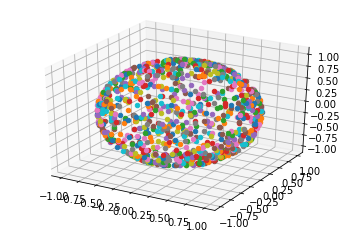

In [ ]:
np.random.seed(10)
tf.random.set_seed(10)

chart1 = Chart([10,2],[tf.nn.tanh,None],[10,3],[tf.nn.tanh,None])
chart2 = Chart([10,2],[tf.nn.tanh,None],[10,3],[tf.nn.tanh, None])
chart3 = Chart([10,2],[tf.nn.tanh,None],[10,3],[tf.nn.tanh, None])
charts = [chart1]
gating_network = Gating_network(output_layer = tf.keras.layers.Dense(len(charts), activation= None),rest_of_the_network = None)


sphere_PCAE = PCAE(charts,gating_network)
sphere_PCAE.charts_weights_inside_norm = False


batch_size = 1000
optimizer = tf.keras.optimizers.Adam(
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-04,
)

for i in range(4):
  sphere_PCAE.compile(optimizer=optimizer)
  sphere_PCAE.fit(uniform_sphere_training_data,epochs=600,batch_size=batch_size)
  [z_test,indices_charts_test,x_reconstructed_test]=sphere_PCAE(uniform_sphere_test_data,training = False)
  [z_training,indices_charts_training,x_reconstructed_training]=sphere_PCAE(uniform_sphere_training_data,training = False)
  sphere_PCAE.create_new_chart(uniform_sphere_test_data,0.01)
  tf.print("Average square error on the test data:")
  tf.print(tf.reduce_mean(tf.reduce_sum(tf.math.square(uniform_sphere_test_data-x_reconstructed_test),axis=1),0))
  sio.savemat("uniform_sphere_output_matlab_"+str(i+1)+"charts.mat", \
       {"test_data": uniform_sphere_test_data.numpy(),\
        "training_data": uniform_sphere_training_data.numpy(),\
        "test_reconstructed": x_reconstructed_test.numpy(), \
        "training_reconstructed": x_reconstructed_training.numpy(), \
        "indices_training": indices_charts_training.numpy(), \
        "indices_test": indices_charts_test.numpy(), \
        "z_training":z_training.numpy(), \
        "z_test":z_test.numpy()})
  

# A faire: voir charts pour training et test
# afficher et les points originaux, et leur reconstruction (avec peut-être une petite flèche?)
# essayer l'affichage surface?
# comparer avec un encoder simple
# tester différentes configurations
# tester sur les autres jeux de données

# Load the data as .mat files



In [ ]:
[_,indices,_] = sphere_PCAE(uniform_sphere_test_data, training = False)
tf.print(indices)

[0 0 0 ... 0 0 0]


### Code from Grobler

In [ ]:
# Author: Jaques Grobler <jaques.grobler@inria.fr>
# License: BSD 3 clause

print(__doc__)

from time import time

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold
from sklearn.utils import check_random_state

# Next line to silence pyflakes.
Axes3D

# Variables for manifold learning.
n_neighbors = 10
n_samples = 1000

# We use a different method

# Create our sphere.
random_state = check_random_state(0)
# temporary
#p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
p = random_state.rand(n_samples) * (2 * np.pi )
t = random_state.rand(n_samples) * np.pi

# Sever the poles from the sphere.
# temporary
# indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
indices = ((t>-1))
# Color and create the points
colors = p[indices]
colors = p
x, y, z = np.sin(t[indices]) * np.cos(p[indices]), \
    np.sin(t[indices]) * np.sin(p[indices]), \
    np.cos(t[indices])

# Grid version for plotting purposes
x_grid=[]
y_grid=[]
z_grid=[]
for j in np.linspace(0.0, np.pi, num=50):
  for i in np.linspace(0.0, 2*np.pi, num=round(1+50*(np.sin(j) +1))):
    x_grid.append(np.sin(j) * np.cos(i))
    y_grid.append(np.sin(j) * np.sin(i))
    z_grid.append(np.cos(j))

sphere_data_grid=  np.array([x_grid, y_grid, z_grid]).T



# Plot our dataset.
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

ax = fig.add_subplot(251, projection='3d')
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T


sphere_data_matlab = { "angle_sphere_data": sphere_data}
sio.savemat("angle_sphere_data_matlab.mat", sphere_data_matlab)
sphere_data_matlab_grid = { "angle_sphere_data_grid": sphere_data_grid}
sio.savemat("angle_sphere_data_matlab_grid.mat", sphere_data_matlab_grid)


# Perform Locally Linear Embedding Manifold learning
methods = ['standard', 'ltsa', 'hessian', 'modified']
labels = ['LLE', 'LTSA', 'Hessian LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    trans_data = manifold.LocallyLinearEmbedding(n_neighbors, 2, method=method).fit_transform(sphere_data).T
    #trans_data_grid = manifold.LocallyLinearEmbedding(n_neighbors, 2, method=method).fit_transform(sphere_data_grid).T
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(252 + i)
    plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

    sphere_data_matlab = {method+"_LLE_sphere_data": trans_data}
    sio.savemat(method+"_LLE_sphere_data_matlab.mat", sphere_data_matlab)
    #sphere_data_matlab_grid = {method+"_LLE_sphere_data_grid": trans_data_grid}
    #sio.savemat(method+"_LLE_sphere_data_matlab_grid.mat", sphere_data_matlab_grid)

# Perform Isomap Manifold learning.
t0 = time()
trans_data = manifold.Isomap(n_neighbors, n_components=2)\
    .fit_transform(sphere_data).T
trans_data_grid = manifold.Isomap(n_neighbors, n_components=2)\
    .fit_transform(sphere_data_grid).T
   
t1 = time()
print("%s: %.2g sec" % ('ISO', t1 - t0))

ax = fig.add_subplot(257)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
"""
#------
# plot the image on the original map
ax = fig.add_subplot(257, projection='3d')
ax.scatter(x, y, z, c= np.pi*(1 + np.sin(np.linalg.norm(30*trans_data[0:1],axis = 0)) ), cmap=plt.cm.rainbow)
ax.view_init(40, -10)
#------
"""
plt.title("%s (%.2g sec)" % ('Isomap', t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

isomap_sphere_data_matlab = {"isomap_sphere_data": trans_data}
sio.savemat("isomap_sphere_data_matlab.mat", isomap_sphere_data_matlab)
isomap_sphere_data_matlab_grid = {"isomap_sphere_data_grid": trans_data_grid}
sio.savemat("isomap_sphere_data_matlab_grid.mat", isomap_sphere_data_matlab_grid)



# Perform Multi-dimensional scaling.
t0 = time()
mds = manifold.MDS(2, max_iter=100, n_init=1)
trans_data = mds.fit_transform(sphere_data).T
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(258)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

sphere_data_matlab = {"MDS_sphere_data": trans_data}
sio.savemat("MDS_sphere_data_matlab.mat", sphere_data_matlab)

# Perform Spectral Embedding.
t0 = time()
se = manifold.SpectralEmbedding(n_components=2,
                                n_neighbors=n_neighbors)
trans_data = se.fit_transform(sphere_data).T
t1 = time()
print("Spectral Embedding: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(259)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("Spectral Embedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

sphere_data_matlab = { "Spectral_embedding_sphere_data": trans_data}
sio.savemat("Spectral_embedding_sphere_data_matlab.mat", sphere_data_matlab)

# Perform t-distributed stochastic neighbor embedding.
t0 = time()
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
trans_data = tsne.fit_transform(sphere_data).T
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))

ax = fig.add_subplot(2, 5, 10)
plt.scatter(trans_data[0], trans_data[1], c=colors, cmap=plt.cm.rainbow)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

sphere_data_matlab = { "TSNE_sphere_data": trans_data}
sio.savemat("TSNE_sphere_data_matlab.mat", sphere_data_matlab)

plt.show()


## Swiss roll

11.5254469


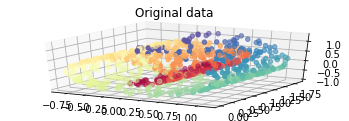

In [ ]:
(swiss_roll_training_data,color_training) = sklearn.datasets.make_swiss_roll(n_samples = 1000, noise = 0.0)
(swiss_roll_test_data,color_test) = sklearn.datasets.make_swiss_roll(n_samples = 1000, noise = 0.0)

std_dataset = tf.cast(tf.math.reduce_euclidean_norm(tf.math.reduce_std(swiss_roll_training_data, axis = 0)),tf.float32)
tf.print(std_dataset)

swiss_roll_training_data /= std_dataset
swiss_roll_test_data /= std_dataset

# This import is needed to modify the way figure behaves
from mpl_toolkits.mplot3d import Axes3D
Axes3D

# Plot dataset

fig = plt.figure()
ax = fig.add_subplot(211, projection='3d')
ax.scatter(swiss_roll_training_data[:, 0], swiss_roll_training_data[:, 1], swiss_roll_training_data[:, 2], c=color_training, cmap=plt.cm.Spectral)
ax.set_title("Original data")

# Plot encoding
"""
#print("Computing LLE embedding")
#X_r, err = manifold.locally_linear_embedding(X, n_neighbors=12,n_components=2)

ax = fig.add_subplot(212)
ax.scatter(X_r[:, 0], X_r[:, 1], c=color, cmap=plt.cm.Spectral)
plt.axis('tight')
plt.xticks([]), plt.yticks([])
plt.title('Projected data')
plt.show()
"""

# Convert to tensor:
swiss_roll_training_data = tf.convert_to_tensor(swiss_roll_training_data, dtype = tf.float32)
swiss_roll_test_data = tf.convert_to_tensor(swiss_roll_test_data, dtype = tf.float32)


In [ ]:

charts = []
rest_of_the_network = tf.keras.Sequential()
#rest_of_the_network.add( tf.keras.layers.Dense(7, activation= "relu"))
rest_of_the_network.add( tf.keras.layers.Dense(7, activation= "tanh"))
for i in range(2):
  charts.append(Chart([5,2],[tf.nn.tanh,None],[5,3],[tf.nn.tanh,None]))
gating_network = Gating_network(output_layer = tf.keras.layers.Dense(len(charts), activation= None),rest_of_the_network = rest_of_the_network)

tf.debugging.enable_check_numerics()

swiss_roll_PCAE = PCAE(charts,gating_network,alpha_load = 0.1, alpha_importance = 0.1, alpha_classification= 0.1, alpha_inverse_reconstruction=0.1)
swiss_roll_PCAE.charts_weights_inside_norm = False

batch_size = 1000
optimizer = tf.keras.optimizers.Adam(
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-04,
)
run_eagerly = True

swiss_roll_PCAE.compile(optimizer=optimizer, run_eagerly=run_eagerly)
optimizer.epsilon = 1e-04 
swiss_roll_PCAE.fit(swiss_roll_training_data,epochs=3000,batch_size=batch_size)
for i in range(9):
  for j, epochs in enumerate([200,700,700]):
    optimizer.epsilon = 1e-04 *10**(1-j)
    swiss_roll_PCAE.compile(optimizer=optimizer, run_eagerly=run_eagerly)
    swiss_roll_PCAE.fit(swiss_roll_training_data,epochs=epochs,batch_size=batch_size)
  [z_test,indices_charts_test,x_reconstructed_test]=swiss_roll_PCAE(swiss_roll_test_data,training = False)
  [z_training,indices_charts_training,x_reconstructed_training]=swiss_roll_PCAE(swiss_roll_training_data,training = False)
   # average error
  tf.print(tf.reduce_mean(tf.reduce_sum(tf.math.square(swiss_roll_test_data-x_reconstructed_test),axis=1),0))
  classes_split = swiss_roll_PCAE.create_new_chart(swiss_roll_training_data,0.0001,clustering_space = "input_space", clustering_alg = "agglom_clustering" )
  sio.savemat("new_chart_classification_"+str(i+1)+".mat", classes_split)
  # Load the data as .mat files
  sio.savemat("swiss_roll_output_matlab_"+str(i+1)+"charts.mat", \
       {"test_data": swiss_roll_test_data.numpy(),\
        "training_data": swiss_roll_training_data.numpy(),\
        "test_reconstructed": x_reconstructed_test.numpy(), \
        "training_reconstructed": x_reconstructed_training.numpy(), \
        "indices_training": indices_charts_training.numpy(), \
        "indices_test": indices_charts_test.numpy(), \
        "z_training":z_training.numpy(), \
        "z_test":z_test.numpy()})
  
  # A faire: voir charts pour training et test
# afficher et les points originaux, et leur reconstruction (avec peut-être une petite flèche?)
# essayer l'affichage surface?
# comparer avec un encoder simple
# tester différentes configurations
# tester sur les autres jeux de données
 

INFO:tensorflow:Enabled check-numerics callback in thread MainThread
Epoch 1/3000
1/1 [==============================] - 40s 40s/step - main reconstruction loss: 2.6988 - number of charts: 2.0000 - load loss: 0.6308 - importance loss: 0.0550 - inverse reconstruction loss: 2.4332 - classification loss: -0.8744
Epoch 2/3000
1/1 [==============================] - 45s 45s/step - main reconstruction loss: 2.6663 - number of charts: 2.0000 - load loss: 0.6172 - importance loss: 0.0527 - inverse reconstruction loss: 2.3752 - classification loss: -0.8725
Epoch 3/3000
1/1 [==============================] - 41s 41s/step - main reconstruction loss: 2.6341 - number of charts: 2.0000 - load loss: 0.6033 - importance loss: 0.0505 - inverse reconstruction loss: 2.3191 - classification loss: -0.8705
Epoch 4/3000
1/1 [==============================] - 41s 41s/step - main reconstruction loss: 2.6024 - number of charts: 2.0000 - load loss: 0.5893 - importance loss: 0.0483 - inverse reconstruction loss: 2

## S curve



fig = plt.figure()
ax = fig.add_subplot(211, projection='3d')
ax.scatter(swiss_roll_data[:, 0], swiss_roll_data[:, 1], swiss_roll_data[:, 2], c=color, cmap=plt.cm.Spectral)
ax.set_title("Original data")

LLE: 0.24 sec
LTSA: 0.41 sec
Hessian LLE: 0.59 sec
Modified LLE: 0.39 sec
Isomap: 0.54 sec
MDS: 3.1 sec
SE: 0.2 sec
t-SNE: 7.7 sec


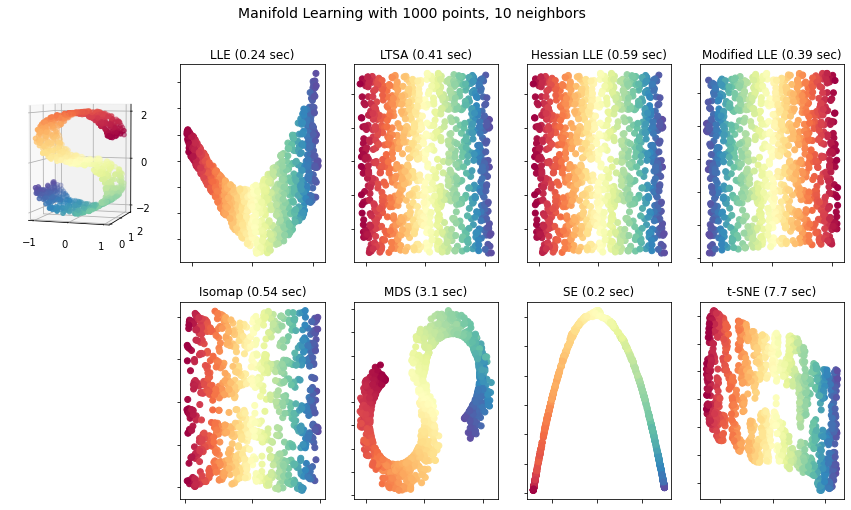

In [ ]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from collections import OrderedDict
from functools import partial
from time import time

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X, color = datasets.make_s_curve(n_points, random_state=0)
n_neighbors = 10
n_components = 2

# Create figure
fig = plt.figure(figsize=(15, 8))
fig.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

# Add 3d scatter plot
ax = fig.add_subplot(251, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.Spectral)
ax.view_init(4, -72)

# Set-up manifold methods
LLE = partial(manifold.LocallyLinearEmbedding,
              n_neighbors, n_components, eigen_solver='auto')

methods = OrderedDict()
methods['LLE'] = LLE(method='standard')
methods['LTSA'] = LLE(method='ltsa')
methods['Hessian LLE'] = LLE(method='hessian')
methods['Modified LLE'] = LLE(method='modified')
methods['Isomap'] = manifold.Isomap(n_neighbors, n_components)
methods['MDS'] = manifold.MDS(n_components, max_iter=100, n_init=1)
methods['SE'] = manifold.SpectralEmbedding(n_components=n_components,
                                           n_neighbors=n_neighbors)
methods['t-SNE'] = manifold.TSNE(n_components=n_components, init='pca',
                                 random_state=0)

# Plot results
for i, (label, method) in enumerate(methods.items()):
    t0 = time()
    Y = method.fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (label, t1 - t0))
    ax = fig.add_subplot(2, 5, 2 + i + (i > 3))
    ax.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.set_title("%s (%.2g sec)" % (label, t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')

plt.show()

## Saving data as MATLAB files

## Simple tests


In [ ]:
a = tf.constant([[1, 2],[3, 4]])

"\n# First create some toy data:\nx = np.linspace(0, 2*np.pi, 400)\ny = np.sin(x**2)\n\n# Create just a figure and only one subplot\nfig, ax = plt.subplots()\nax.plot(x, y)\nax.set_title('Simple plot')\n\n# Create two subplots and unpack the output array immediately\nf, (ax1, ax2) = plt.subplots(1, 2, sharey=True)\nax1.plot(x, y)\nax1.set_title('Sharing Y axis')\nax2.scatter(x, y)\n\n# Create four polar axes and access them through the returned array\nfig, axs = plt.subplots(2, 2, subplot_kw=dict(polar=True))\naxs[0, 0].plot(x, y)\naxs[1, 1].scatter(x, y)\n\n# Share a X axis with each column of subplots\nplt.subplots(2, 2, sharex='col')\n\n# Share a Y axis with each row of subplots\nplt.subplots(2, 2, sharey='row')\n\n# Share both X and Y axes with all subplots\nplt.subplots(2, 2, sharex='all', sharey='all')\n\n# Note that this is the same as\nplt.subplots(2, 2, sharex=True, sharey=True)\n\n# Create figure number 10 with a single subplot\n# and clears it if it already exists.\nfig, ax 

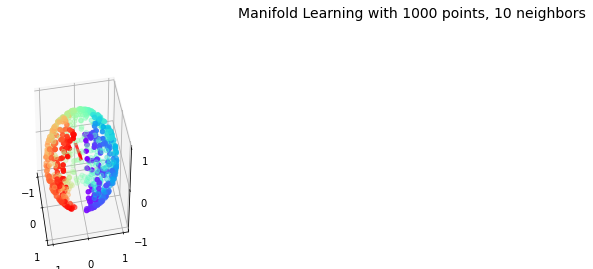

In [ ]:


# Next line to silence pyflakes.
Axes3D
# Create our sphere.
random_state = check_random_state(0)
p = random_state.rand(n_samples) * (2 * np.pi - 0.55)
t = random_state.rand(n_samples) * np.pi

# Sever the poles from the sphere.
indices = ((t < (np.pi - (np.pi / 8))) & (t > ((np.pi / 8))))
colors = p[indices]
x, y, z = np.sin(t[indices]) * np.cos(p[indices]), \
    np.sin(t[indices]) * np.sin(p[indices]), \
    np.cos(t[indices])


# Plot our dataset.
fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

ax = fig.add_subplot(251, projection='3d')
ax.scatter(x, y, z, c=p[indices], cmap=plt.cm.rainbow)
ax.view_init(40, -10)

sphere_data = np.array([x, y, z]).T


ax.quiver(x[0], y[0], z[0], # <-- starting point of vector
        0 - x[0], 0 - y[0], 0 - z[0], # <-- directions of vector
        color = 'red', alpha = .8, lw = 3,
    )

"""
# First create some toy data:
x = np.linspace(0, 2*np.pi, 400)
y = np.sin(x**2)

# Create just a figure and only one subplot
fig, ax = plt.subplots()
ax.plot(x, y)
ax.set_title('Simple plot')

# Create two subplots and unpack the output array immediately
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing Y axis')
ax2.scatter(x, y)

# Create four polar axes and access them through the returned array
fig, axs = plt.subplots(2, 2, subplot_kw=dict(polar=True))
axs[0, 0].plot(x, y)
axs[1, 1].scatter(x, y)

# Share a X axis with each column of subplots
plt.subplots(2, 2, sharex='col')

# Share a Y axis with each row of subplots
plt.subplots(2, 2, sharey='row')

# Share both X and Y axes with all subplots
plt.subplots(2, 2, sharex='all', sharey='all')

# Note that this is the same as
plt.subplots(2, 2, sharex=True, sharey=True)

# Create figure number 10 with a single subplot
# and clears it if it already exists.
fig, ax = plt.subplots(num=10, clear=True)
"""